In [2]:
import gffutils
import pickle
from overlap_calc import *


In [55]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
anocar_db = gffutils.FeatureDB('anocar.db')
anocar_canons = list(canonical_transcripts(anocar_db, r'./Anolis_carolinensis.AnoCar2.0.dna.toplevel.fa'))
cpgs_anocar = load_cpg_gff(anocar_db)

In [4]:
anocar_overlap = cpg_overlap(anocar_canons, cpgs_anocar, pre_tss=300, post_tss=100)

In [5]:
cpgs_anocar_liver = load_cpg_bed('/home/evgeny/tau/gen_cpg/anocar_liver_nmi.bed')
anocar_overlap_liver = cpg_overlap(anocar_canons, cpgs_anocar_liver, pre_tss=300, post_tss=100)

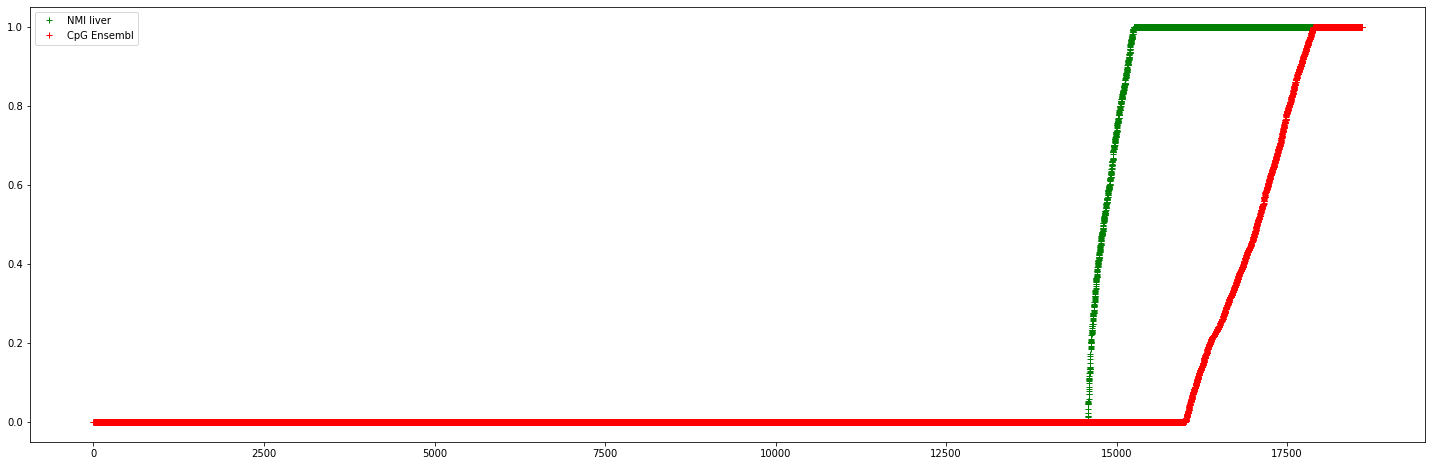

In [6]:
from matplotlib import pyplot
fig, ax = pyplot.subplots(figsize=(25,8))
pyplot.plot([anocar_overlap_liver[k] for k in sorted(anocar_overlap_liver.keys(), key=lambda k: anocar_overlap_liver[k])], 'g+', label='NMI liver')
pyplot.plot([anocar_overlap[k] for k in sorted(anocar_overlap.keys(), key=lambda k: anocar_overlap[k])], 'r+', label='CpG Ensembl')
pyplot.legend()
pyplot.show()

In [ ]:
from homologs import paralogs
branch_points=paralogs(gffutils.FeatureDB('anocar.db'), r'./Anolis_carolinensis.AnoCar2.0.dna.toplevel.fa', '28377')            
cpg_less, cpg_full = [set(s) for s in split_overlaps(anocar_overlap_liver)]

This is just a histogram (which nearly matches between the NMI data from different tissues), we also need to check correlations

In [8]:
branch_points.keys()

dict_keys(['Vertebrata', 'Chordata', 'Gnathostomata', 'Bilateria', 'Anolis carolinensis', 'Euteleostomi', 'Sauria', 'Tetrapoda', 'Amniota', 'Sarcopterygii', 'Opisthokonta', 'Iguania', 'Episquamata', 'Toxicofera', 'Lepidosauria'])

In [9]:
import numpy as np
np.corrcoef(
    [
        [anocar_overlap_liver[k] for k in sorted(anocar_overlap.keys())], 
        [anocar_overlap[k] for k in sorted(anocar_overlap.keys())]
    ])

array([[1.        , 0.25318633],
       [0.25318633, 1.        ]])

In [10]:
cpg_less, cpg_full = [set(s) for s in split_overlaps(anocar_overlap_liver)]

In [11]:
from seaborn import violinplot, despine, boxplot
from pandas import DataFrame
from matplotlib import pyplot

In [ ]:
branch_order = ["Opisthokonta", "Bilateria", "Chordata", "Vertebrata", "Gnathostomata", "Euteleostomi", "Sarcopterygii", "Tetrapoda", "Amniota", 
               "Sauria", "Lepidosauria", "Episquamata", "Toxicofera", "Iguania", "Anolis carolinensis"]
frame=DataFrame.from_records(sum([[(s, (g[0] in cpg_full) + (g[1] in cpg_full), g[2], g[3], g[6], g[4], g[5], g[0], g[1]) for g in p] for s,p in ((s, branch_points[s]) for s in branch_order)], []), columns=["Branch point", "CpG-ness", "dN", "dS", "Similarity", "Length", "Distance", "g1", "g2"])


<AxesSubplot:xlabel='Branch point', ylabel='Length'>

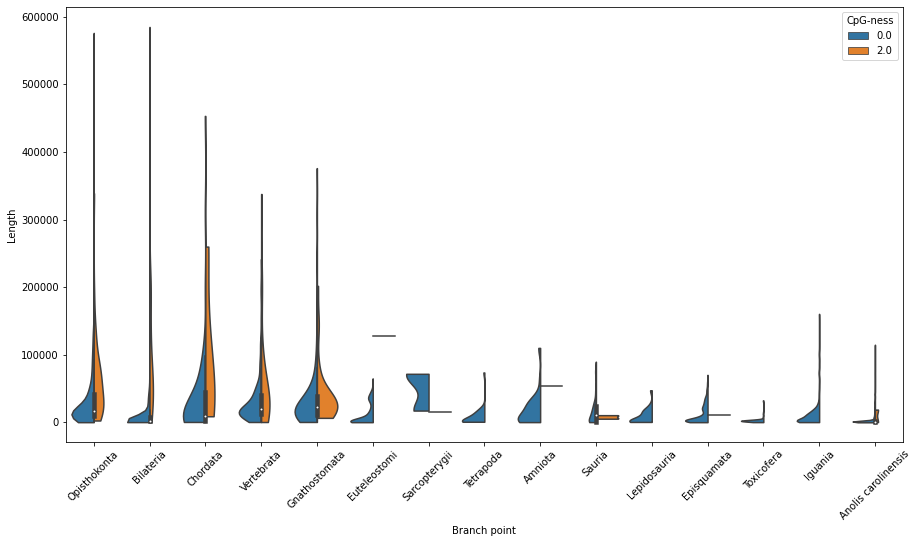

In [13]:
fig, ax = pyplot.subplots(figsize=(15,8))
pyplot.xticks(rotation=45)
violinplot(ax=ax, x="Branch point", y="Length", hue="CpG-ness", cut=0, data=frame.where(frame["CpG-ness"] != 1), split=True)


<AxesSubplot:xlabel='Branch point', ylabel='Distance'>

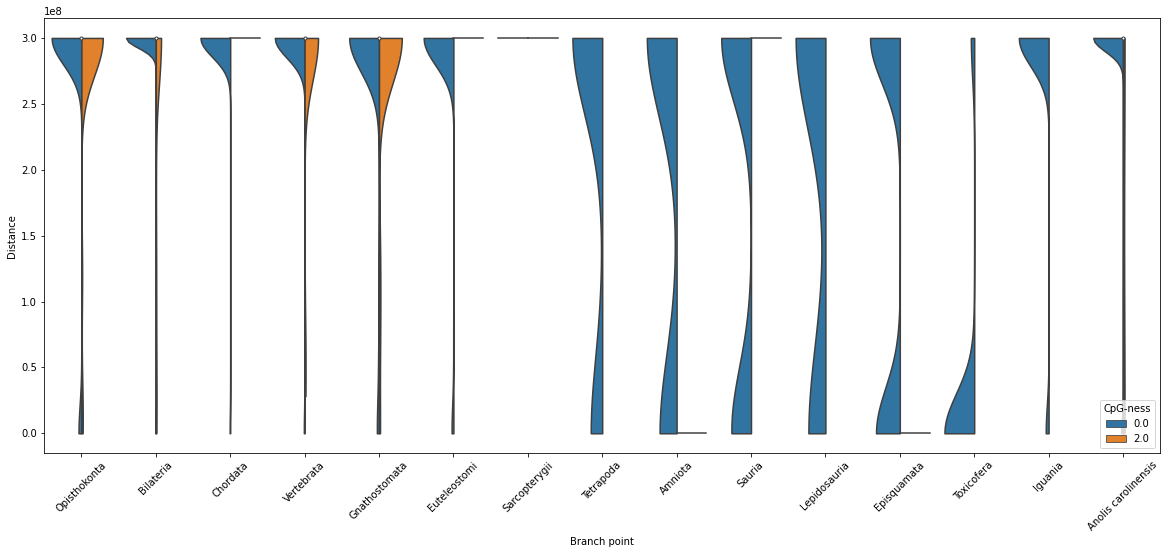

In [14]:
fig, ax = pyplot.subplots(figsize=(20, 8))
pyplot.xticks(rotation=45)
violinplot(ax=ax, x="Branch point", y="Distance", hue="CpG-ness", cut=0, data=frame.where(frame["CpG-ness"] != 1), split=True)

<AxesSubplot:xlabel='Branch point', ylabel='count'>

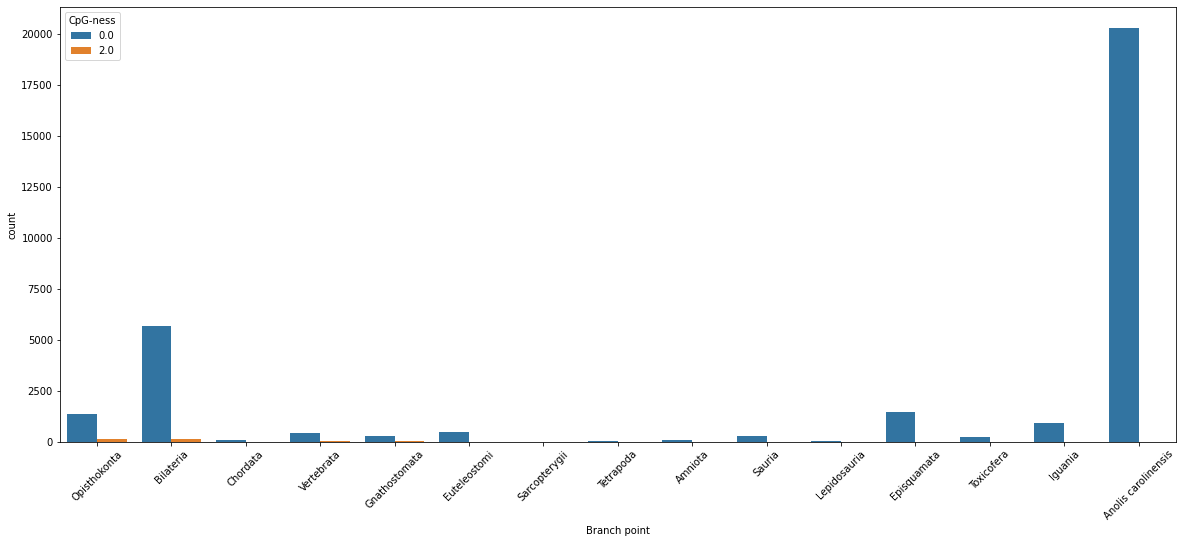

In [15]:
from seaborn import countplot
fig, ax = pyplot.subplots(figsize=(20, 8))
pyplot.xticks(rotation=45)
countplot(ax=ax, x="Branch point", hue="CpG-ness", data=frame.where(frame["CpG-ness"] != 1))

In [16]:
from math import *
import csv
from collections import namedtuple
species = set()
o2os = { k:set() for k in anocar_overlap.keys() }
ortho = namedtuple('one2one', ['lgene', 'lspecies', 'rgene', 'rspecies'])
with open('/data/db/one2one.csv') as file:
    for o in (ortho(l['gl.stable_id'], l['namel.name'], l['gr.stable_id'], l['namer.name']) for l in csv.DictReader(file, fieldnames=['gl.stable_id', 'namel.name', 'gr.stable_id', 'namer.name'], quotechar='"')):
        species.add(o.rspecies)
        if 'gene:'+o.lgene in o2os:
            o2os['gene:'+o.lgene].add(o.rspecies)


In [34]:
species=species.difference([s for s in species if not any(s in o2os[g] for g in anocar_overlap.keys())])

In [50]:
from seaborn import violinplot, despine, boxplot, barplot
from pandas import DataFrame
from matplotlib import pyplot
cpg_less_elife = set(dt[dt['CpG eLife']==0]['Gene'])
cpg_full_elife = set(dt[dt['CpG eLife']==1]['Gene'])

frameo=DataFrame.from_records([(bo, len([g for g in cpg_less if bo in o2os[g]])/len(cpg_less), 0) for bo in species]+
                             [(bo, len([g for g in cpg_full if bo in o2os[g]])/len(cpg_full), 1) for bo in species], columns=['Species', 'Orthologs', 'CpG-ness'])
frameo=frameo.sort_values("Orthologs", ascending=False)
frameelife=DataFrame.from_records([(bo, len([g for g in cpg_less_elife if bo in o2os[g]])/len(cpg_less_elife), 0) for bo in species]+
                             [(bo, len([g for g in cpg_full_elife if bo in o2os[g]])/len(cpg_full_elife), 1) for bo in species], columns=['Species', 'Orthologs', 'CpG-ness'])
frameelife=frameelife.sort_values("Orthologs", ascending=False)


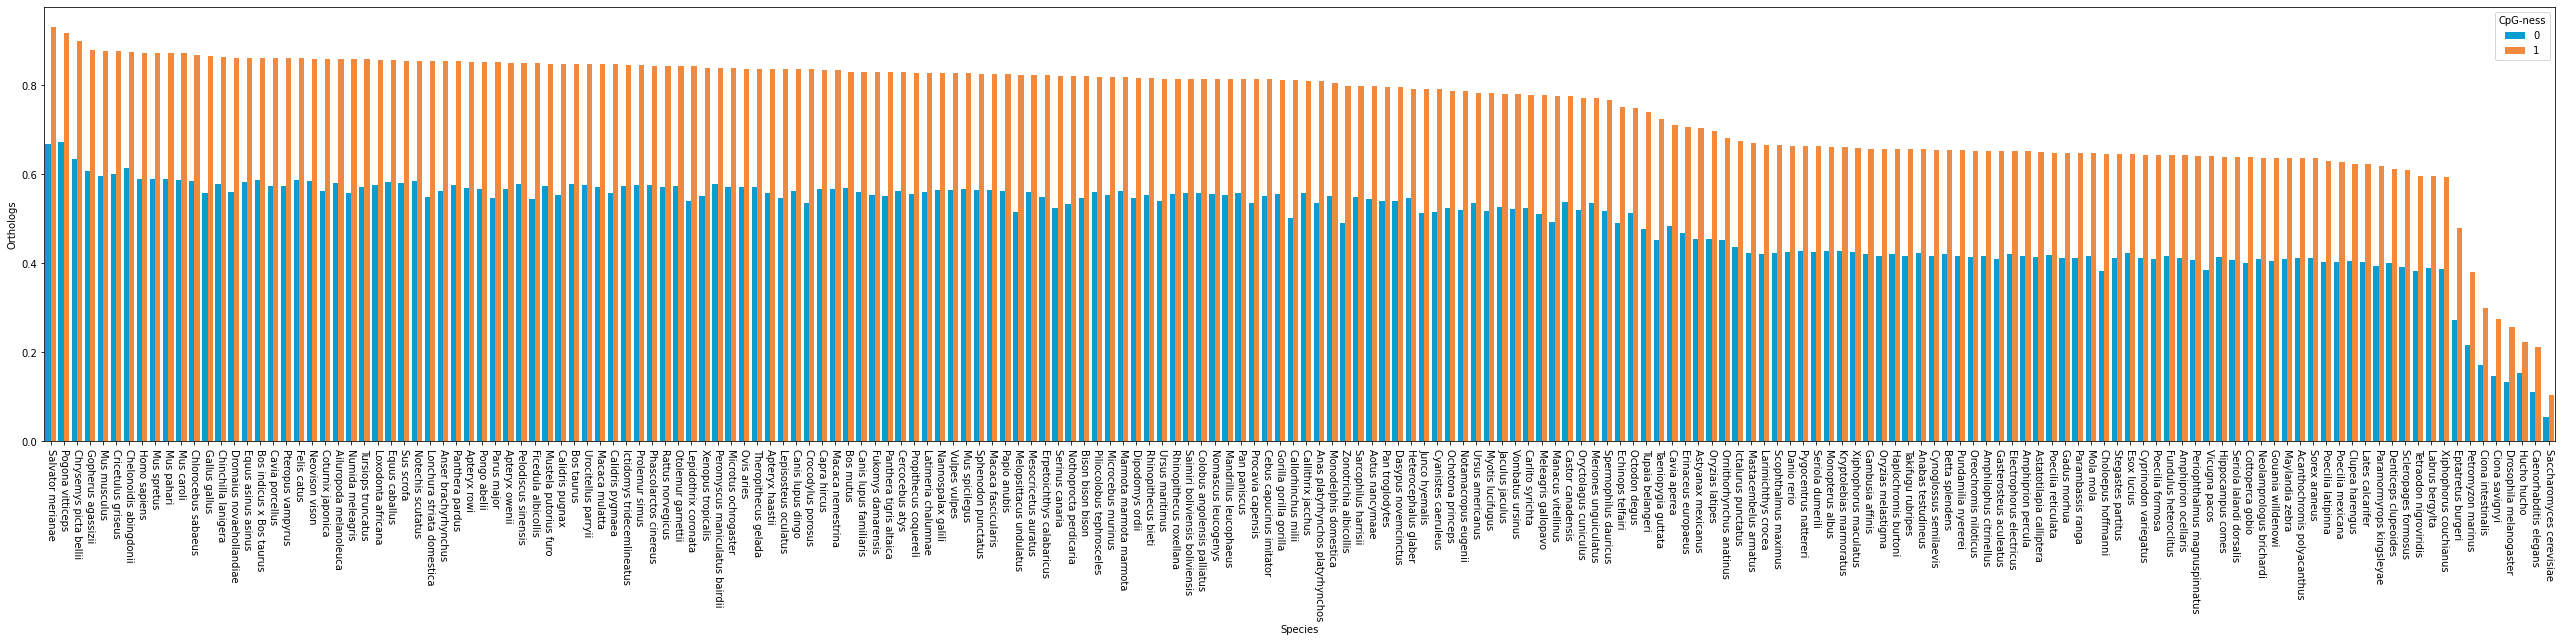

In [63]:
fig, ax = pyplot.subplots(figsize=(45,8))
pyplot.xticks(rotation=-90)
barplot(ax=ax, data=frameo, x="Species", y="Orthologs", hue="CpG-ness", saturation=1.0, palette = ['#0B9DCF', '#EF893D'])
fig.savefig('ortho-one-to-one-species-lizard-by-cgi-bars.pdf')

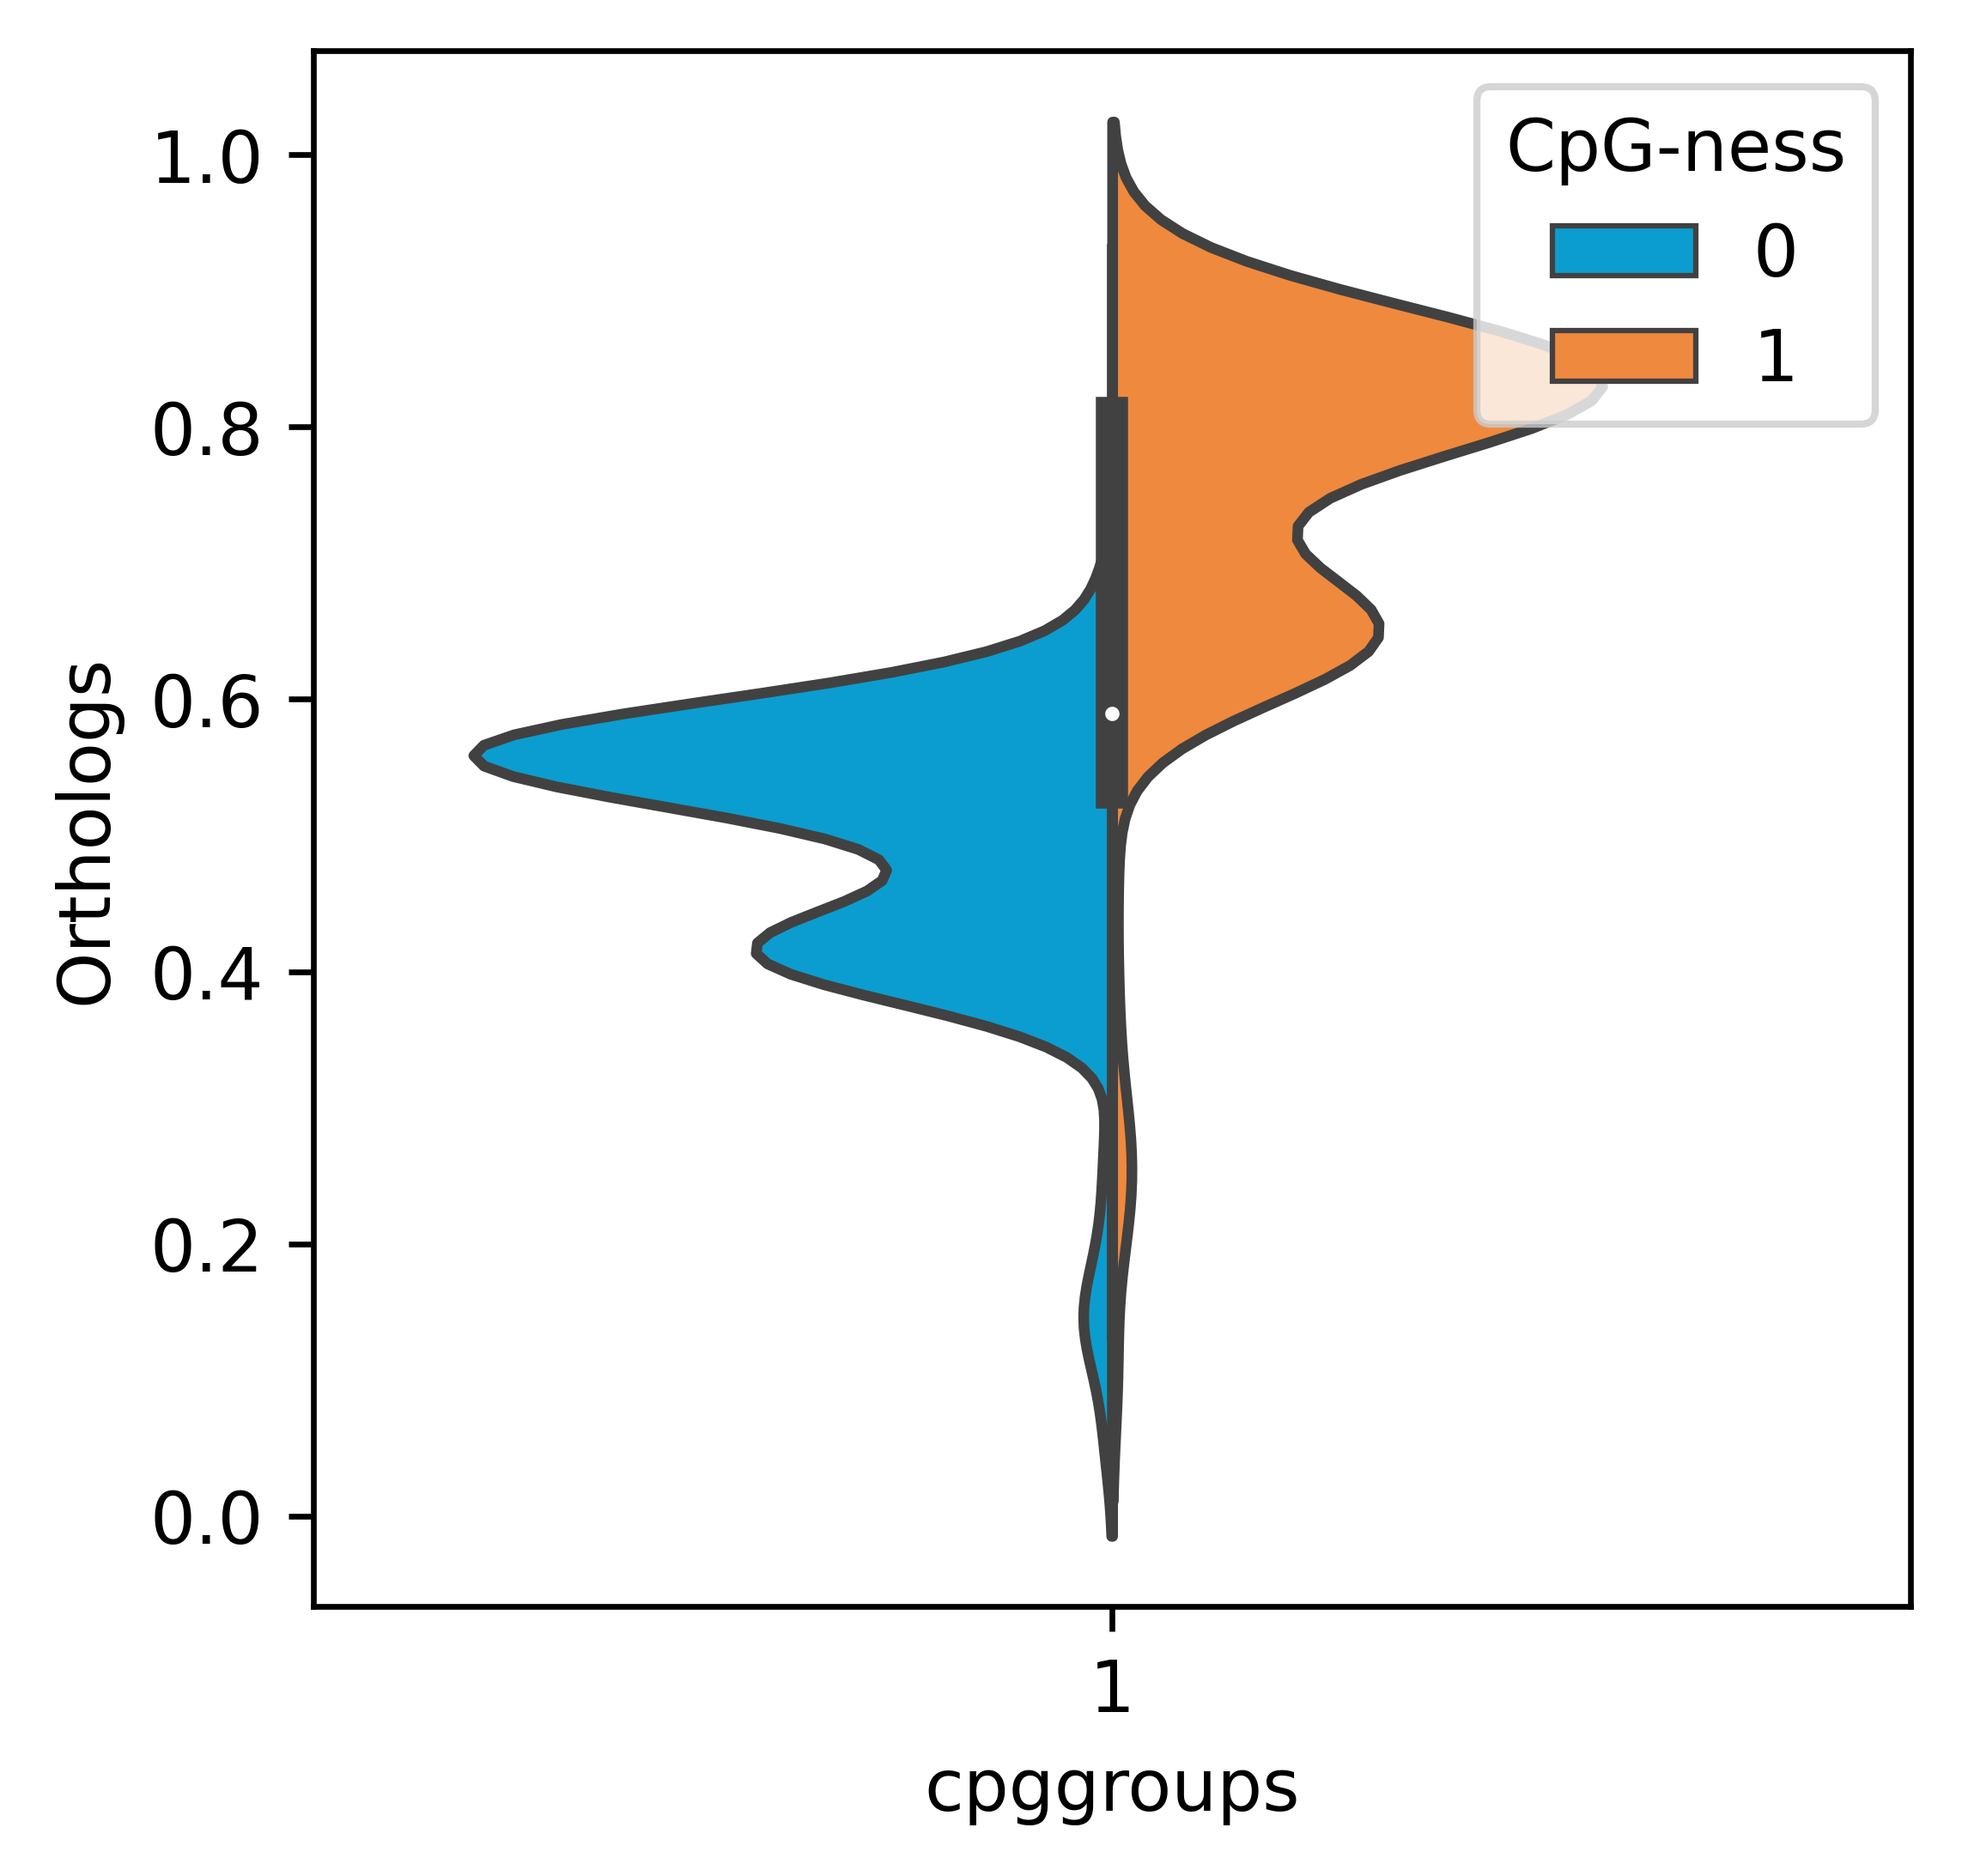

In [64]:
from seaborn import violinplot
fig,ax = pyplot.subplots(figsize=(4,4), dpi=600)
violinplot(ax=ax, data=frameo.assign(cpggroups=1), x="cpggroups", y="Orthologs", hue="CpG-ness", split=True, saturation=1.0, palette = ['#0B9DCF', '#EF893D'])
fig.savefig('ortho-one-to-one-species-lizard-by-cgi-violin.pdf')

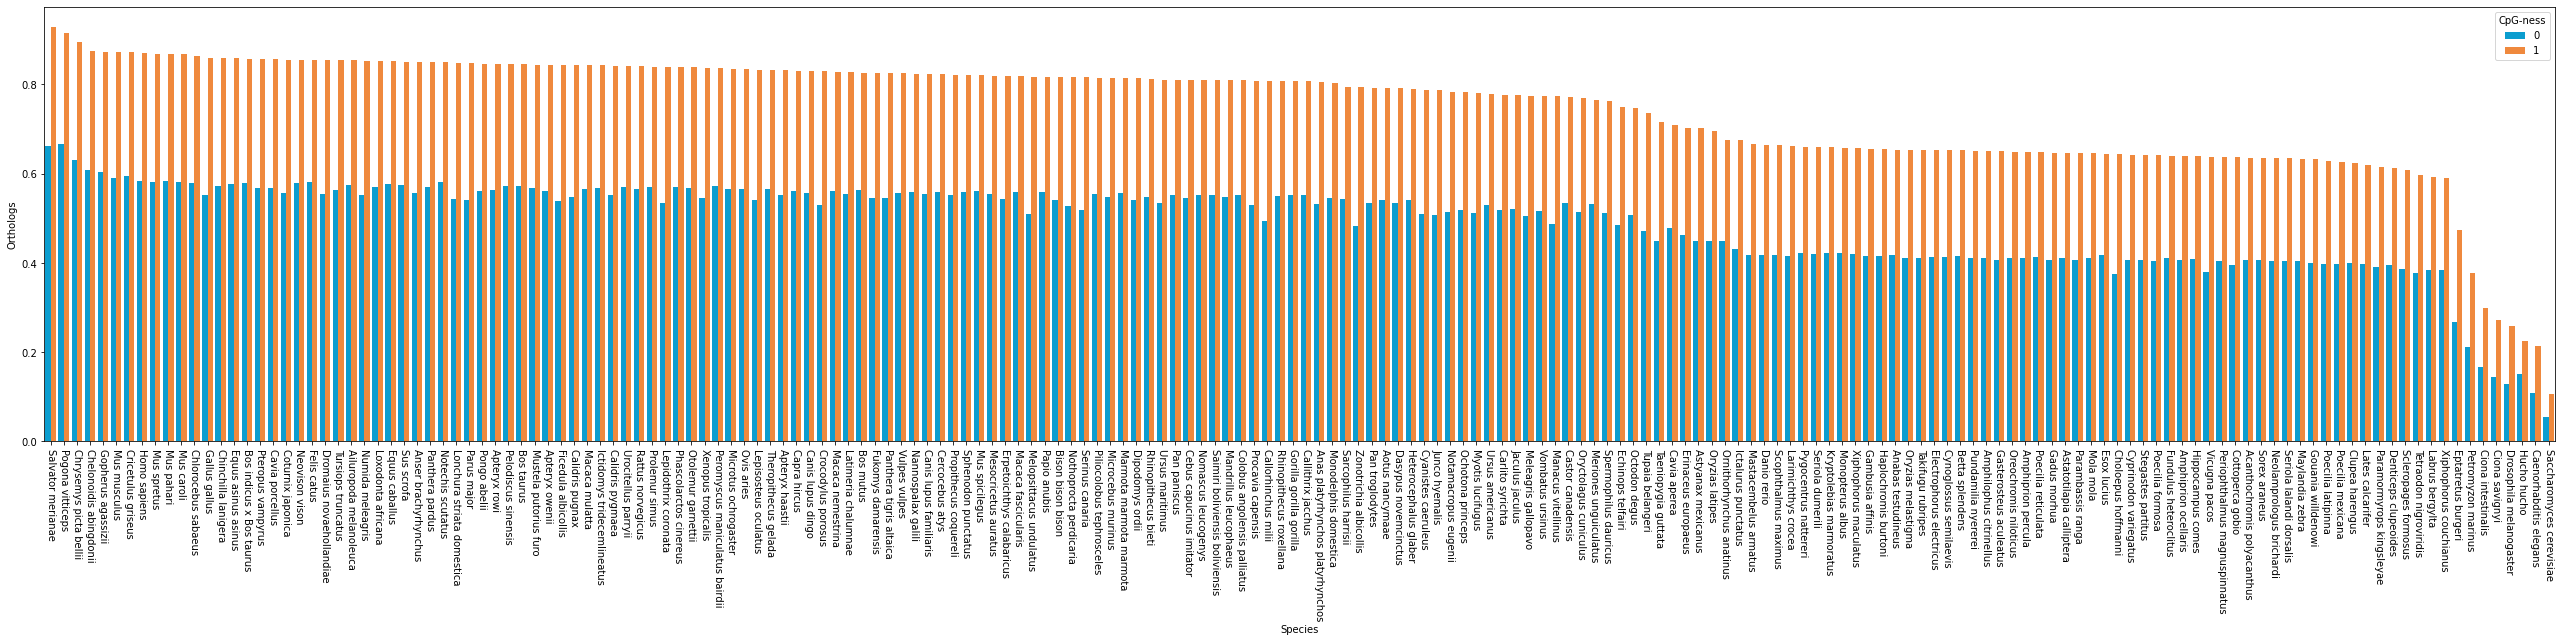

In [65]:
fig, ax = pyplot.subplots(figsize=(45,8))
pyplot.xticks(rotation=-90)
barplot(ax=ax, data=frameelife, x="Species", y="Orthologs", hue="CpG-ness", saturation=1.0, palette = ['#0B9DCF', '#EF893D'])
fig.savefig('ortho-one-to-one-species-lizard-by-cgi-bars-elife.pdf')

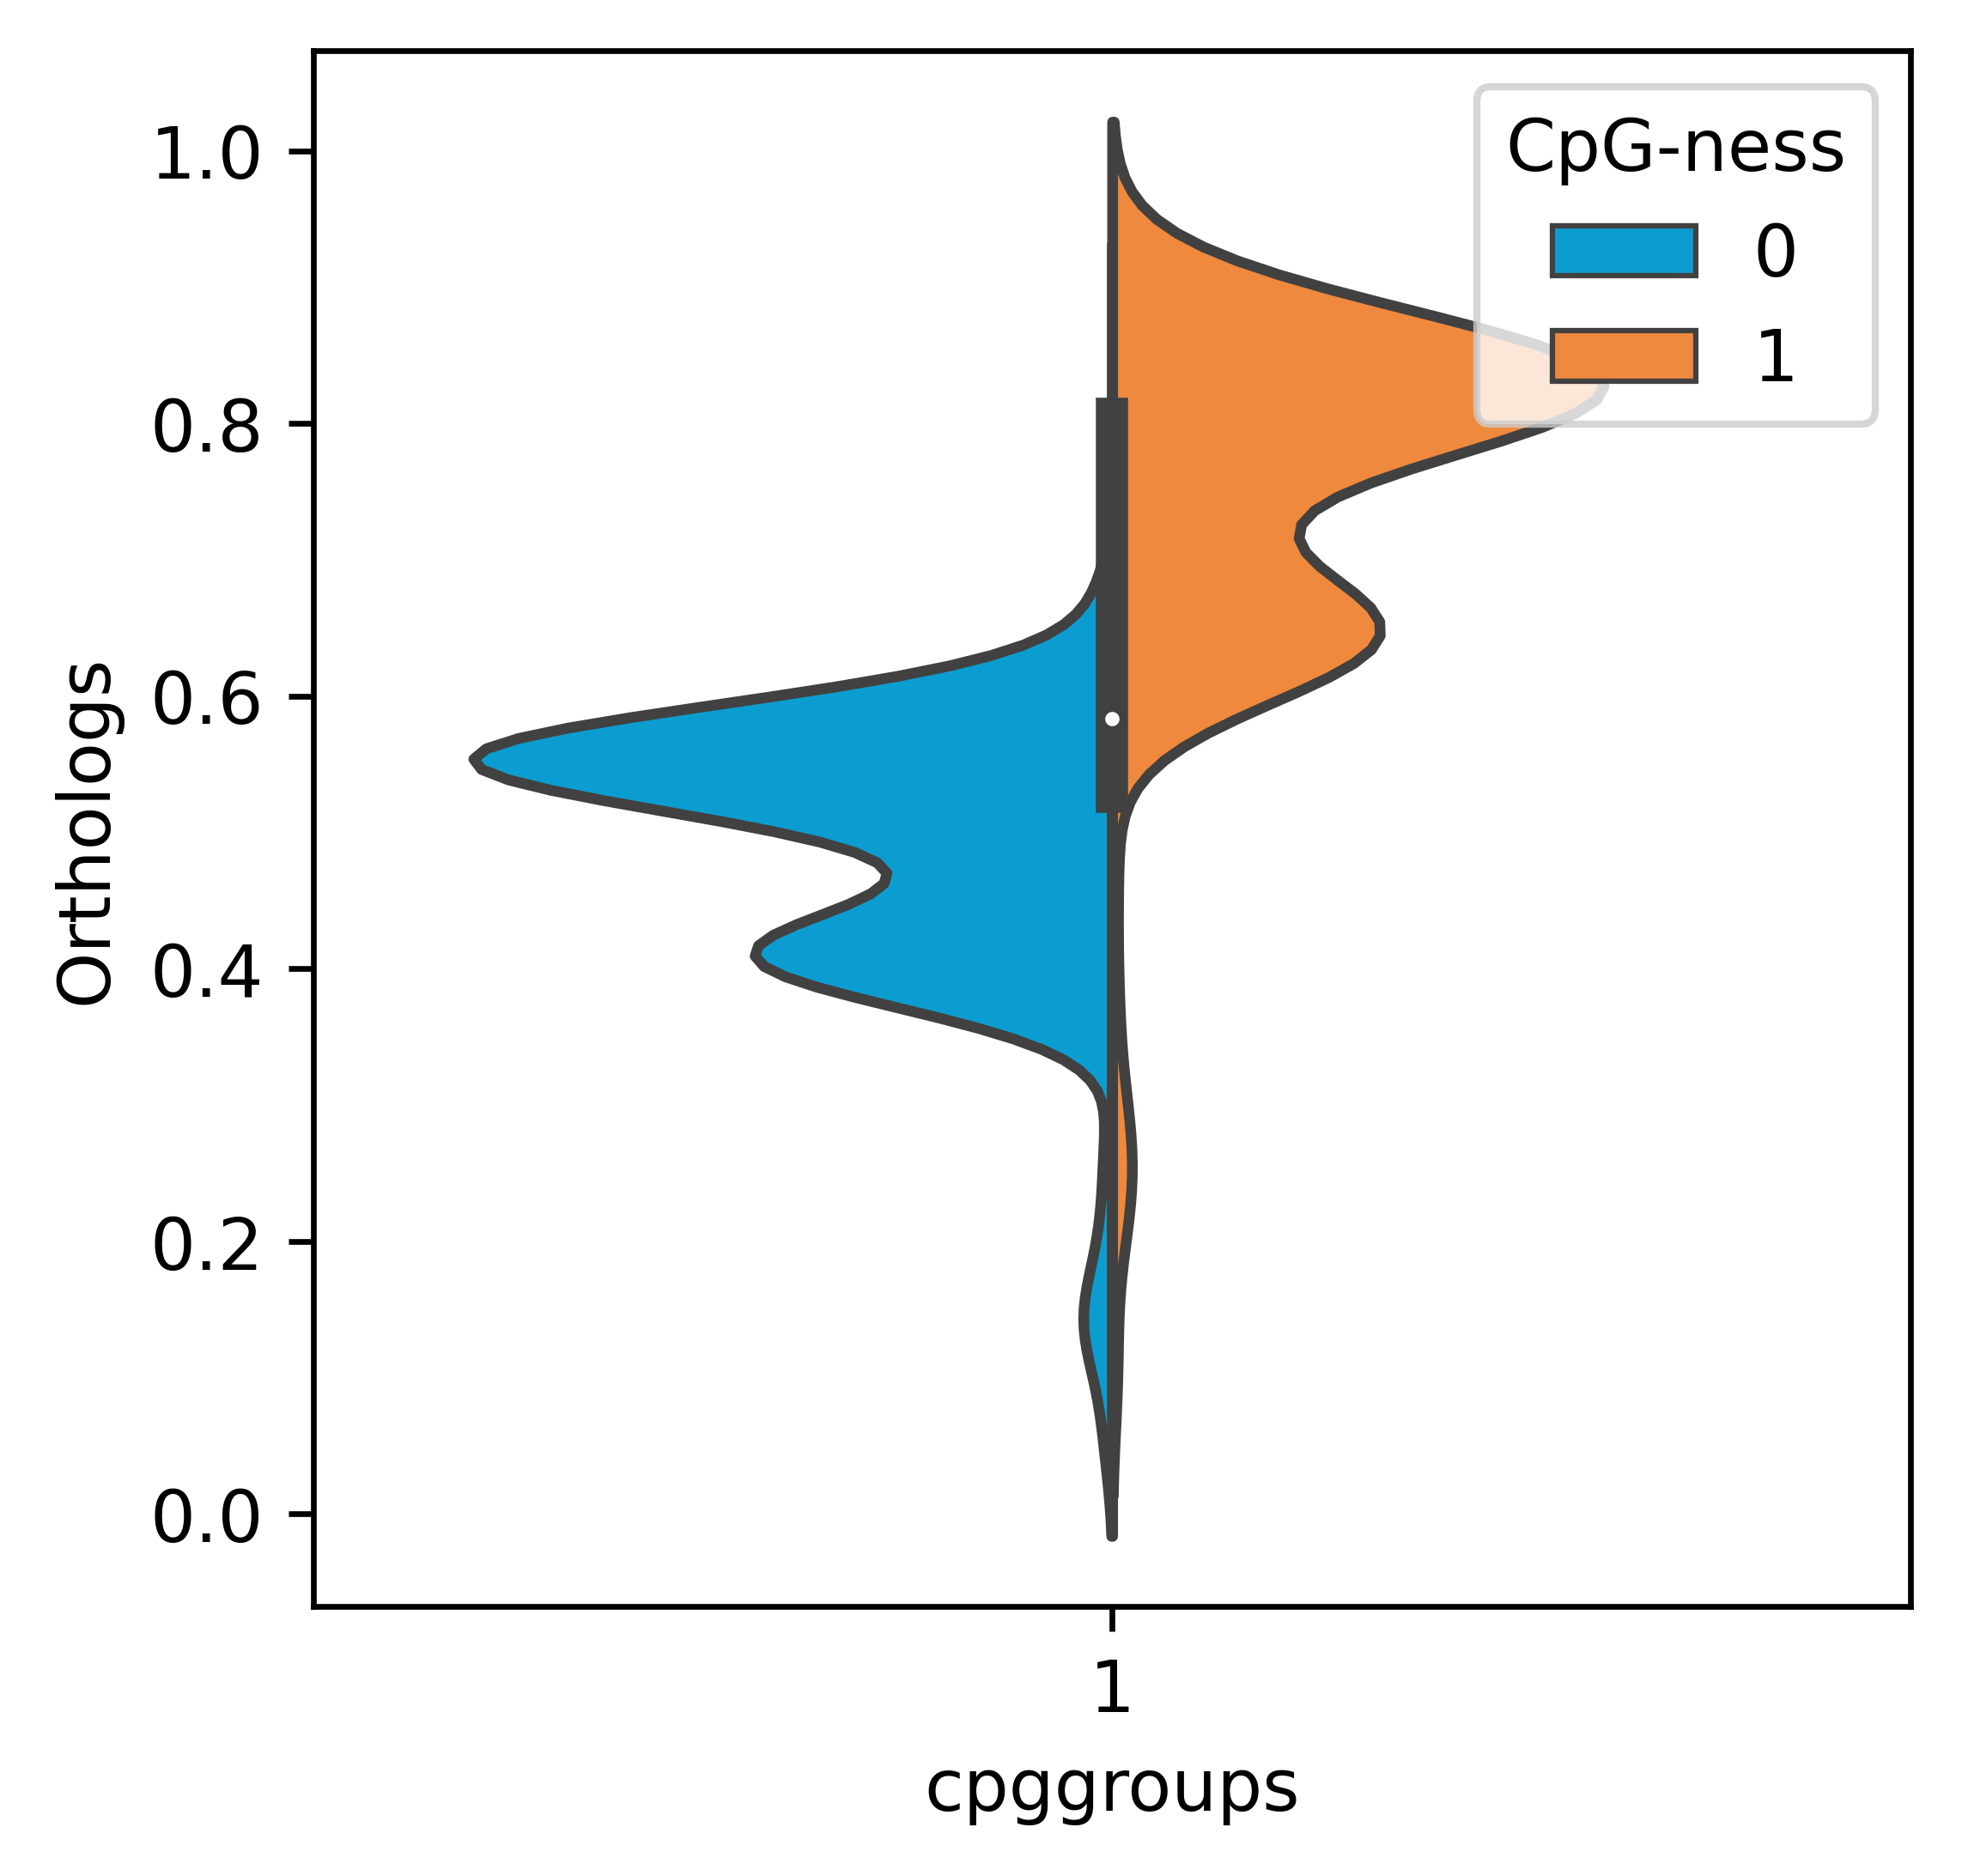

In [66]:
from seaborn import violinplot
fig,ax = pyplot.subplots(figsize=(4,4), dpi=600)
violinplot(ax=ax, data=frameelife.assign(cpggroups=1), x="cpggroups", y="Orthologs", hue="CpG-ness", split=True, saturation=1.0, palette = ['#0B9DCF', '#EF893D'])
fig.savefig('ortho-one-to-one-species-lizard-by-cgi-violin-elife.pdf')

<AxesSubplot:xlabel='Species', ylabel='Orthologs'>

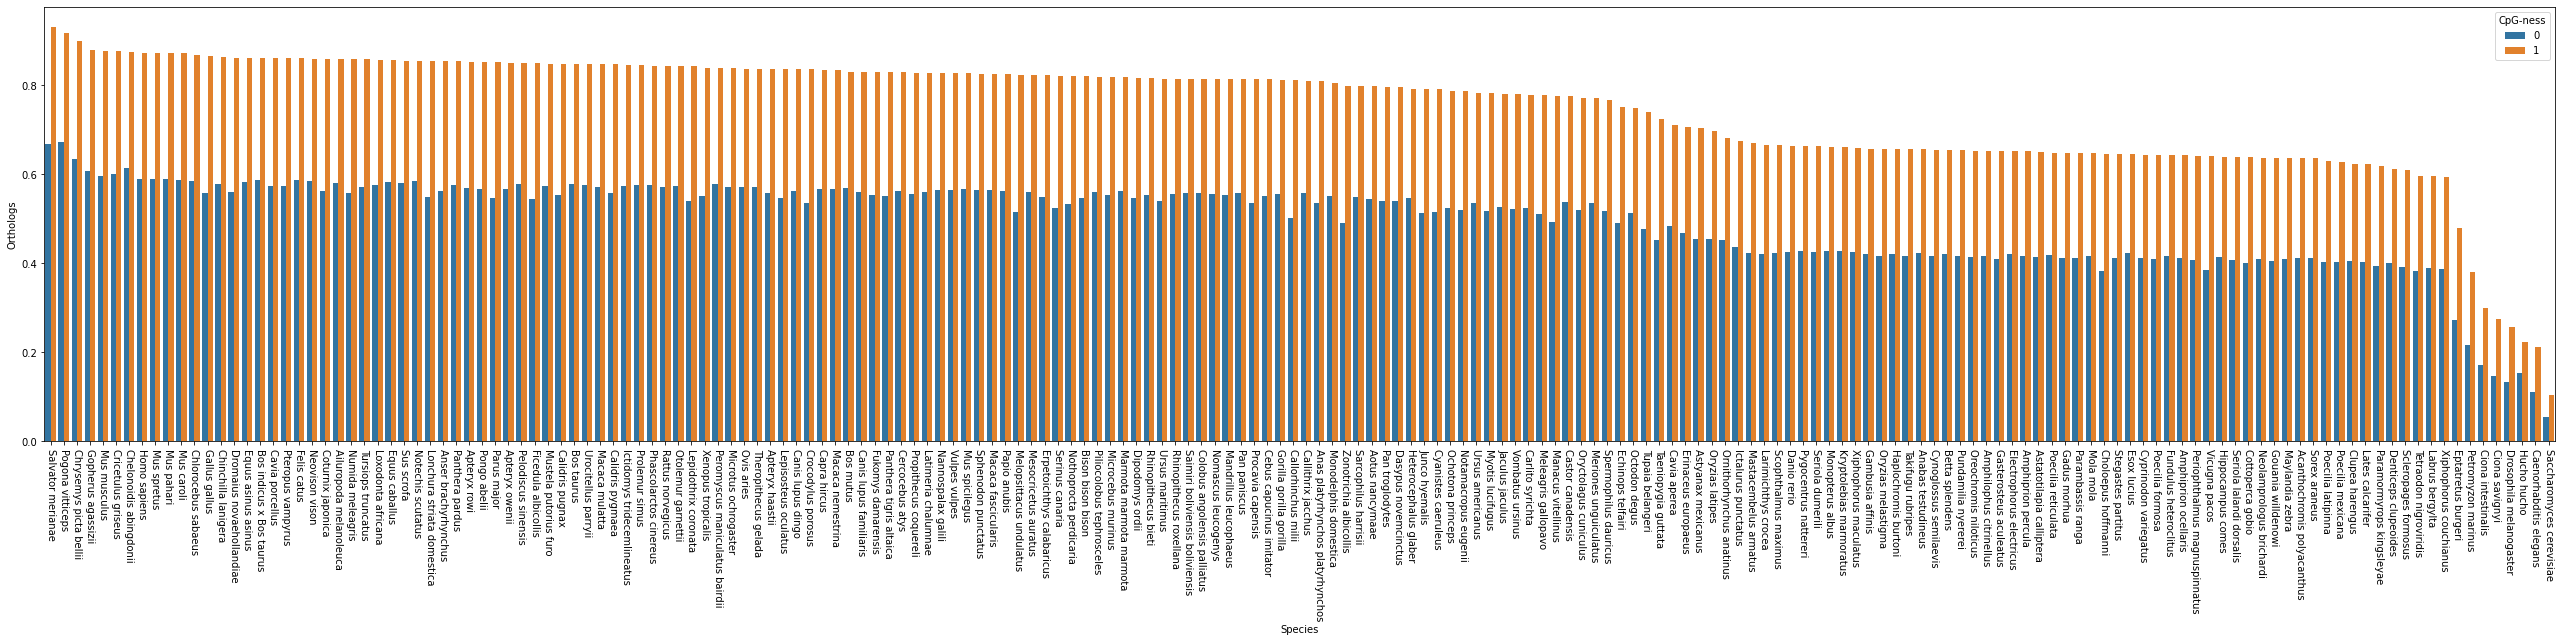

In [37]:
fig, ax = pyplot.subplots(figsize=(45,8))
pyplot.xticks(rotation=-90)
barplot(ax=ax, data=frameo, x="Species", y="Orthologs", hue="CpG-ness")

<AxesSubplot:xlabel='CpG-ness', ylabel='Orthologs'>

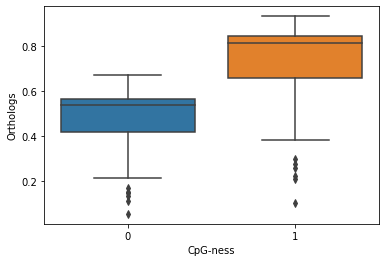

In [38]:
boxplot(data=frameo, x="CpG-ness", y="Orthologs")

In [ ]:
def descriptions(db):
    for gene in db.features_of_type('gene'):
        yield gene.id,  gene.attributes['description'][0] if 'description' in gene.attributes else ''

descr = dict(descriptions(anocar_db))        
ordered = ordered_cpgs(cpgs_anocar_liver)
dt=DataFrame.from_records([(g, canons[g][0].chrom, canons[g][0].start, canons[g][0].end, canons[g][0].end-canons[g][0].start, len(canons[g][1]), canons[g][2], descr[g],
                            anocar_overlap_liver[g], 1.0 if nmi_tss(canons[g][0].chrom, canons[g][0].start if canons[g][0].strand=='+' else canons[g][0].end, ordered) else 0.0
                           ) for g in canons.keys()], columns=['Gene', 'Chromosome', 'Start', 'End', 'Gene length', 'Transcript Length', 'First intron', 'Description', 'CpG overlap', 'CpG eLife'])

import qgrid
import ipywidgets as widgets
widget=qgrid.show_grid(dt, show_toolbar=True)
widget
#dt

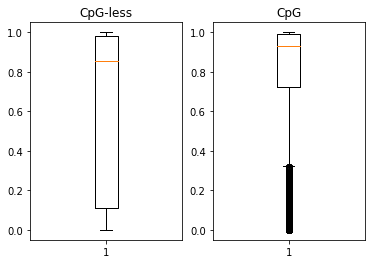

In [60]:
from matplotlib import pyplot as plt
fam_pvalues = {'gene:'+v.split()[0]:float(v.split()[1]) for v in open('anocar-genes-p-value.txt').readlines()}
plt.subplot(1,2,1, title='CpG-less')
plt.boxplot([fam_pvalues[g] for g in cpg_less if g in fam_pvalues])
plt.subplot(1,2,2, title='CpG')
plt.boxplot([fam_pvalues[g] for g in cpg_full if g in fam_pvalues])
plt.savefig('anocar-gene-gain-and-loss-pvalue.pdf', dpi=600)
 

In [41]:
import homologs
from homologs import ortholog_count_by_gene
exp_genes = dt.set_index('Gene')
exp_genes=exp_genes.join(ortholog_count_by_gene(canons.keys())).assign(index=lambda x: [v[5:] for v in x.index]).set_index('index')
exp_genes=exp_genes.assign(gain_and_loss_pval=lambda x: [fam_pvalues['gene:'+p] for p in x.index if 'gene:'+p in fam_pvalues else None])
exp_genes.to_csv('lizard-genes.csv')

KeyError: 'gene:ENSACAG00000026428'

In [47]:
can_fr=DataFrame.from_records([((k,)+v) for k,v in canons.items()], columns=['gene', 'feature', 'seq', 'first_intron', 'introns']).set_index('gene')
def coldec(postfix):
    return lambda c: c.replace('(','-').replace(')','-')+'-'+postfix
export=frame.join(can_fr[['first_intron', 'introns']].rename(columns=coldec('g1')), on='g1').\
             join(can_fr[['first_intron', 'introns']].rename(columns=coldec('g2')), on='g2')
export[export['g1']<export['g2']].to_csv('lizard-paralogs.csv')

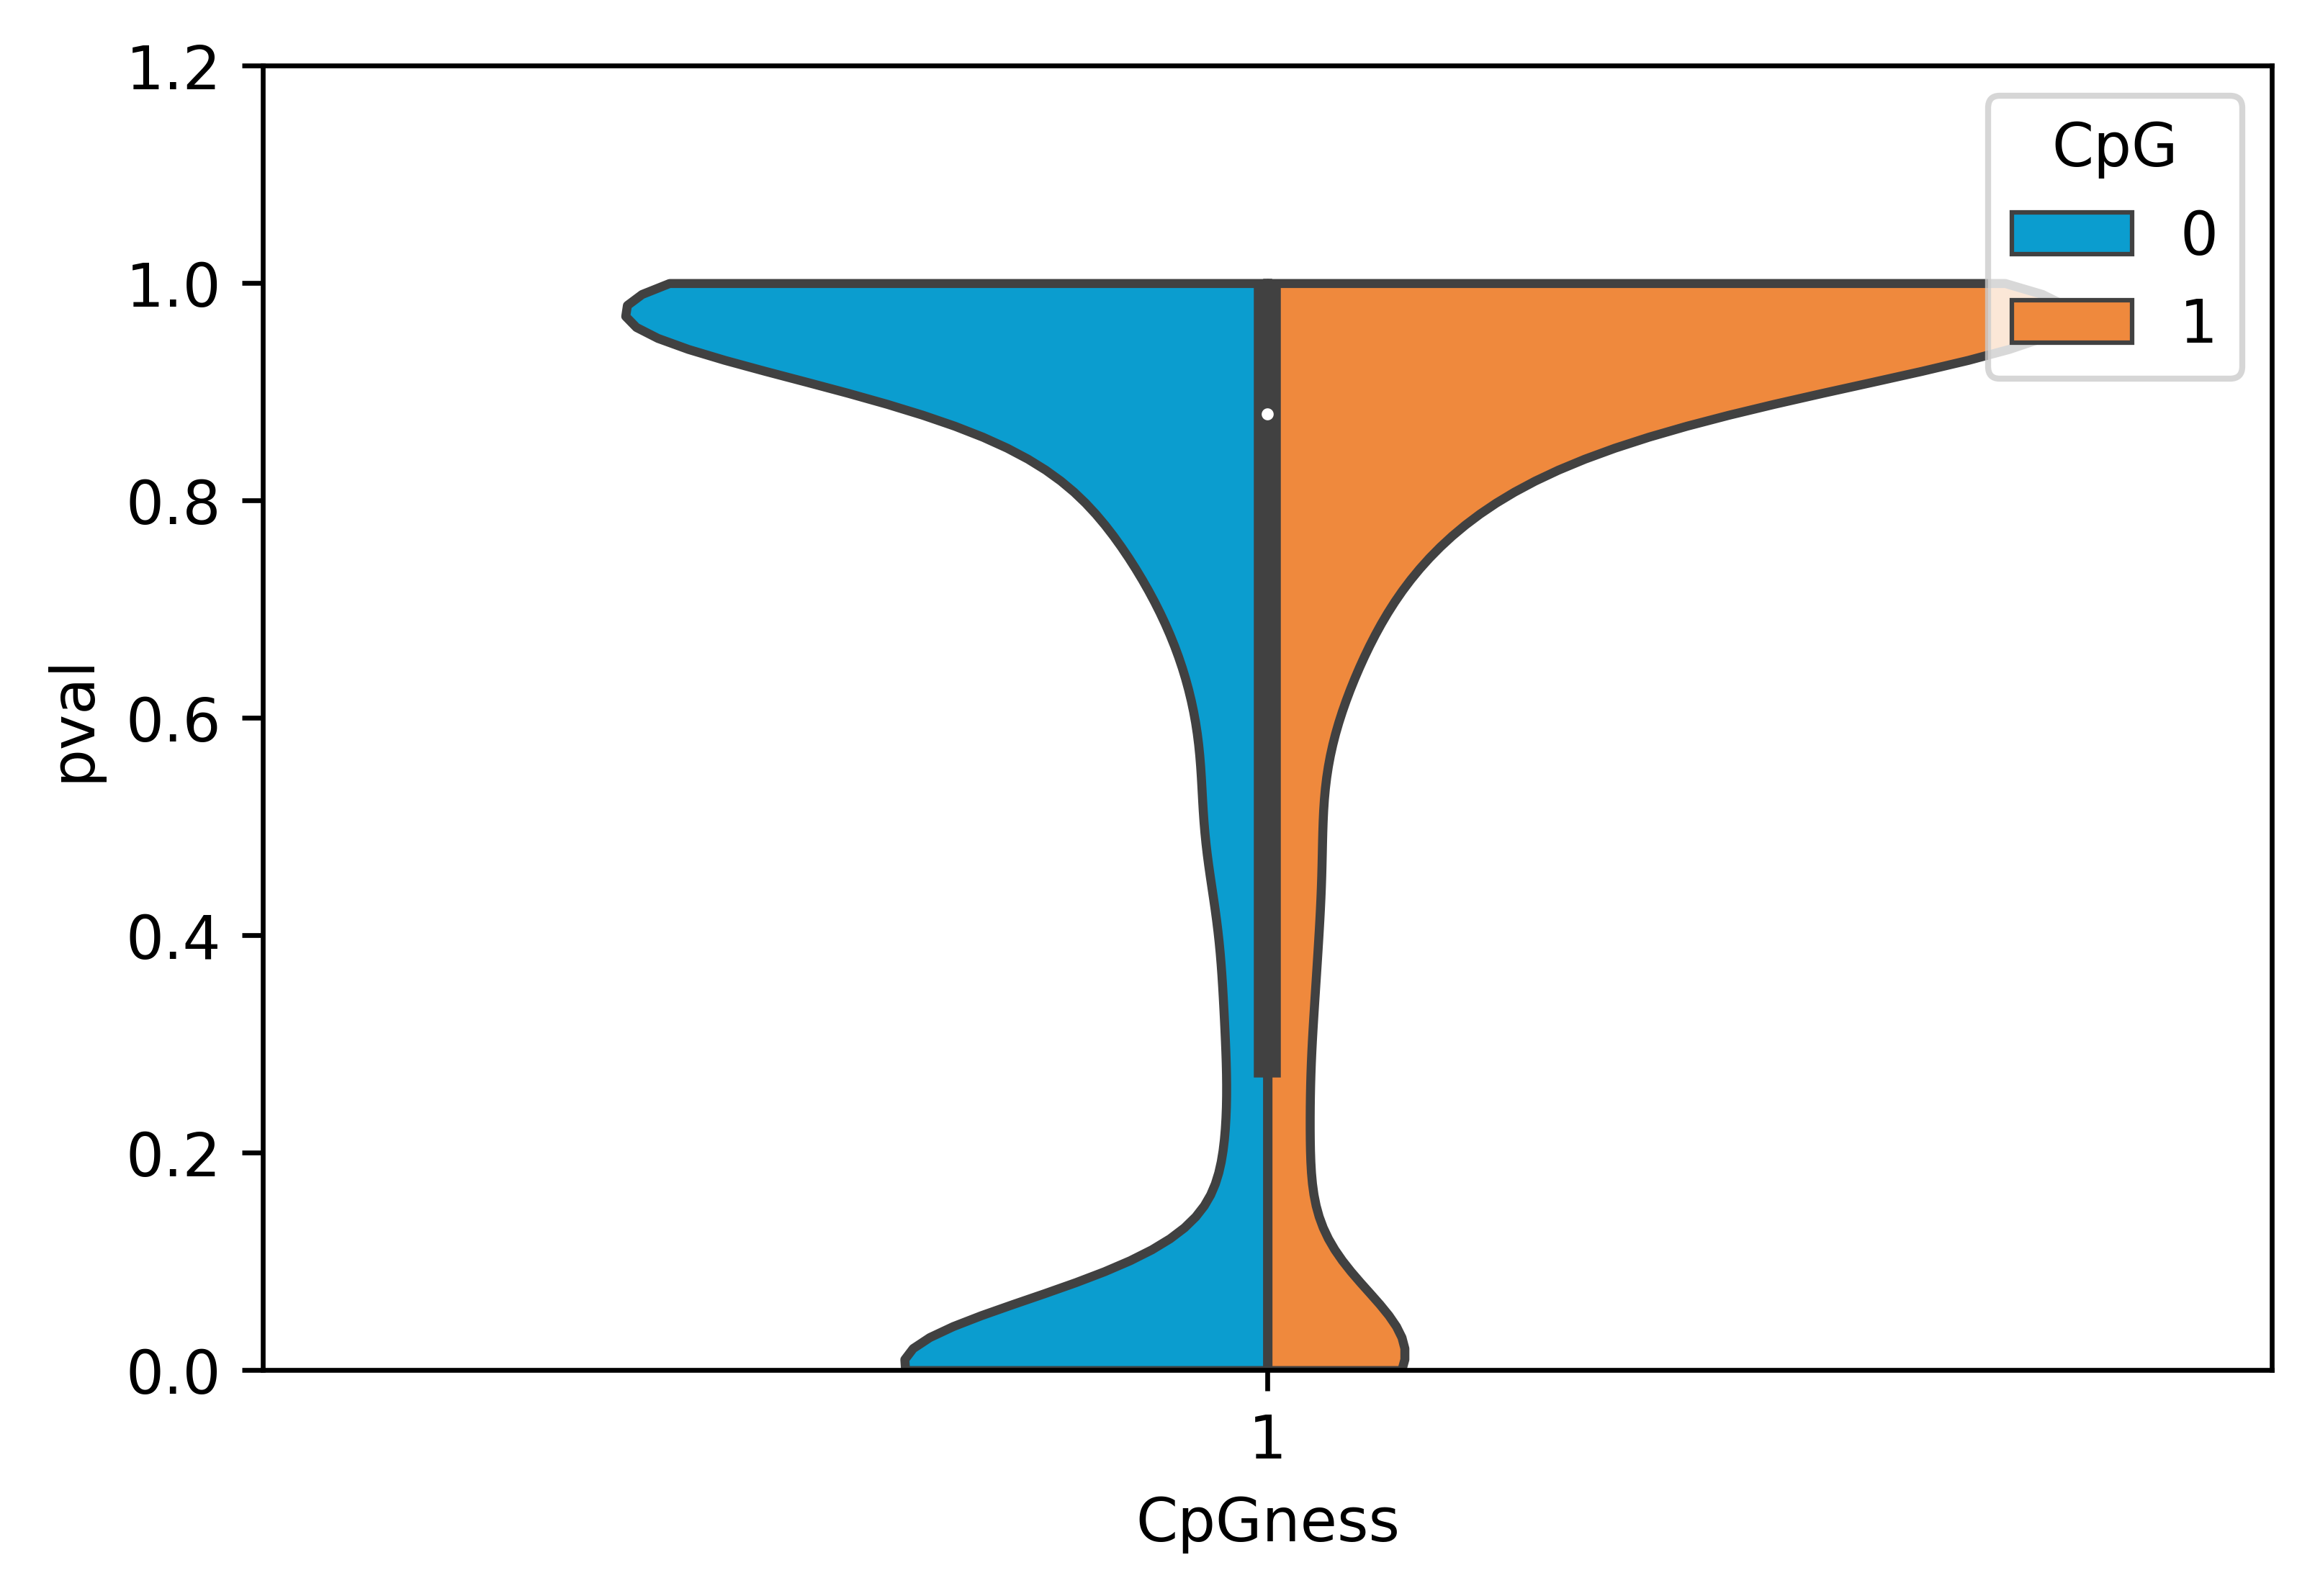

In [67]:
from matplotlib import pyplot as plt
from seaborn import violinplot
import pandas as pd
fam_pvalues = {'gene:'+v.split()[0]:float(v.split()[1]) for v in open('anocar-genes-p-value.txt').readlines()}
fig, ax = plt.subplots(dpi=600)
plt.ylim(0.0, 1.2)
violinplot(ax=ax, data=pd.concat((DataFrame({'pval':[fam_pvalues[g] for g in cpg_less if g in fam_pvalues]}).assign(CpG=0), DataFrame({'pval':[fam_pvalues[g] for g in cpg_full if g in fam_pvalues]}).assign(CpG=1))).assign(CpGness=1),
           x='CpGness', y='pval', hue='CpG', split=True, cut=0, saturation=1.0, palette = ['#0B9DCF', '#EF893D'])
plt.savefig('anocar-gene-gain-and-loss-pvalue-violin.pdf')
 

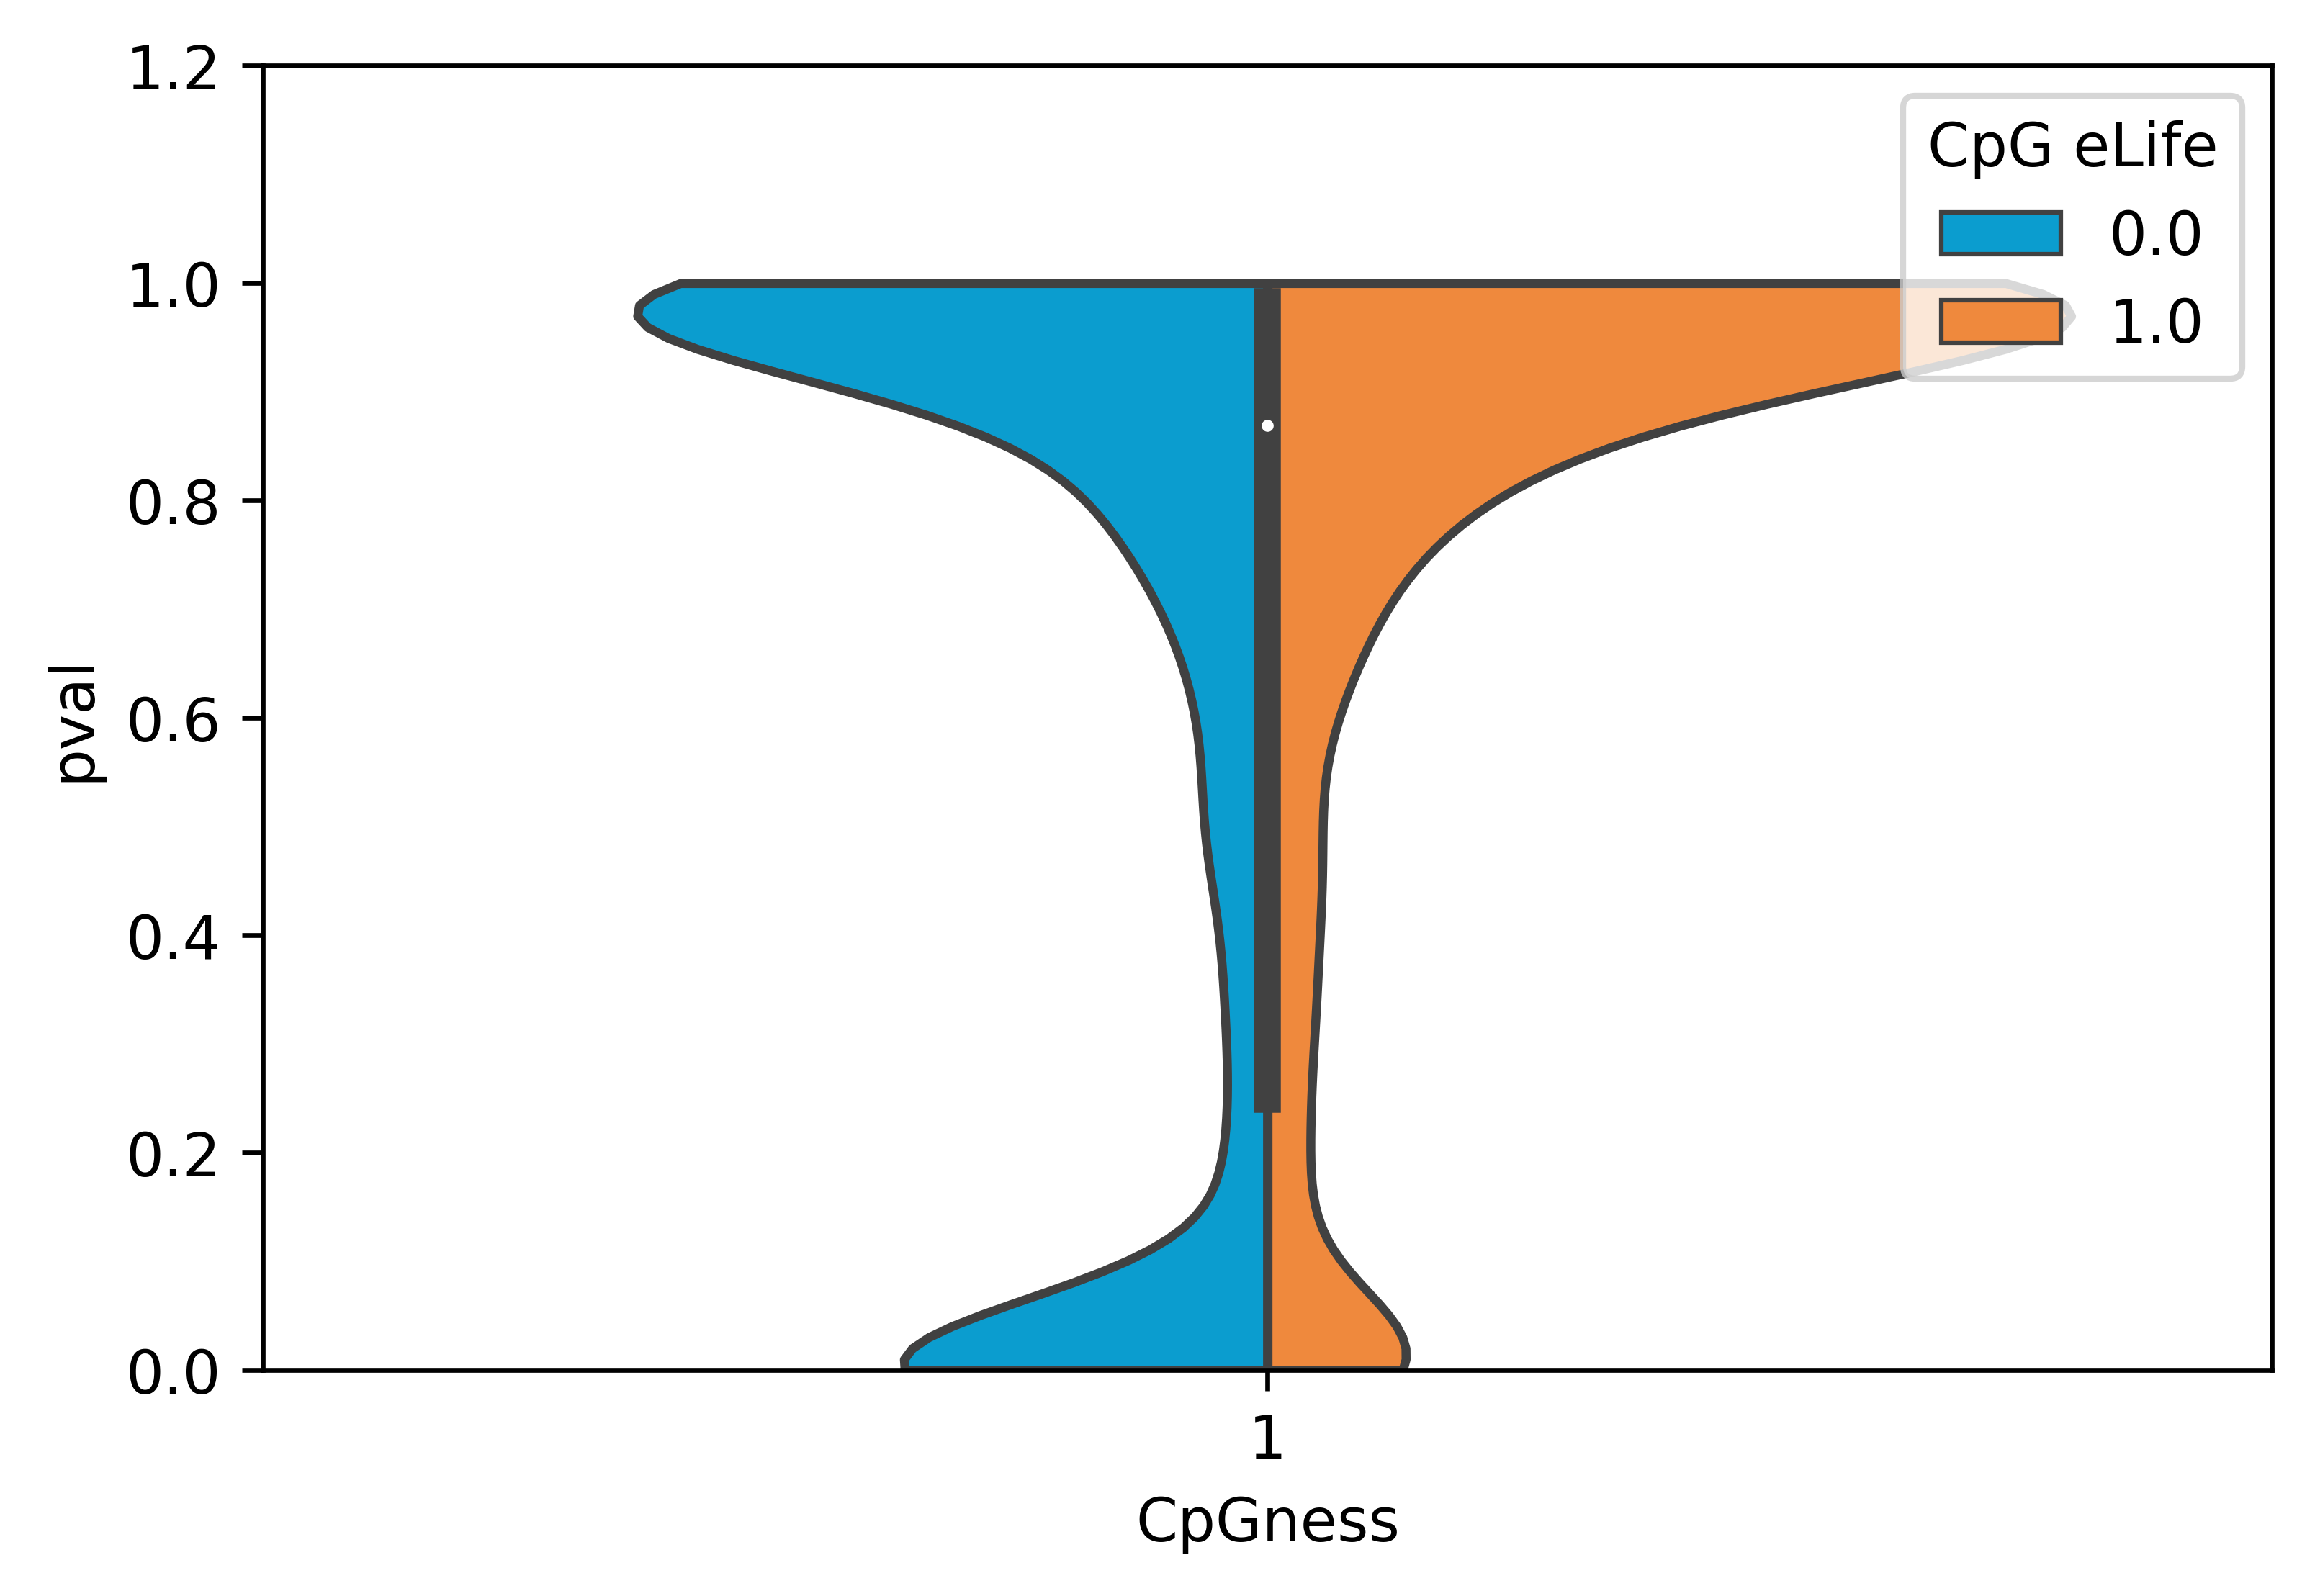

In [68]:
from matplotlib import pyplot as plt
from seaborn import violinplot
import pandas as pd
fam_pvalues = {v.split()[0]:float(v.split()[1]) for v in open('anocar-genes-p-value.txt').readlines()}
fig, ax = plt.subplots(dpi=600)
plt.ylim(0.0, 1.2)
violinplot(ax=ax, data=DataFrame.from_dict(fam_pvalues, orient='index', columns=['pval']).join(exp_genes['CpG eLife']).assign(CpGness=1),
           x='CpGness', y='pval', hue='CpG eLife', split=True, cut=0, saturation=1.0, palette = ['#0B9DCF', '#EF893D'])
plt.savefig('lizard-gene-gain-and-loss-pvalue-violin-elife.pdf')
 

In [46]:
from scipy.stats import mannwhitneyu
print('Mann-Whitney on -300+100: 50%% %s'%str(mannwhitneyu([fam_pvalues[g] for g in dt[dt['CpG overlap']<0.5]['Gene'] if g in fam_pvalues], [fam_pvalues[g] for g in dt[dt['CpG overlap']>=0.5]['Gene'] if g in fam_pvalues], alternative='less')))
print('Mann-Whitney on -1000+1000: 1bp %s'%str(mannwhitneyu([fam_pvalues[g] for g in dt[dt['CpG eLife']<0.5]['Gene'] if g in fam_pvalues], [fam_pvalues[g] for g in dt[dt['CpG eLife']>=0.5]['Gene'] if g in fam_pvalues], alternative='less')))

Mann-Whitney on -300+100: 50% MannwhitneyuResult(statistic=21976813.0, pvalue=2.2165979115134262e-61)
Mann-Whitney on -1000+1000: 1bp MannwhitneyuResult(statistic=23423403.5, pvalue=8.748530890234585e-68)
